In [62]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.datasets import make_circles
%matplotlib inline

In [63]:
data,target = make_circles(n_samples=1000,noise=0.05,random_state=42)


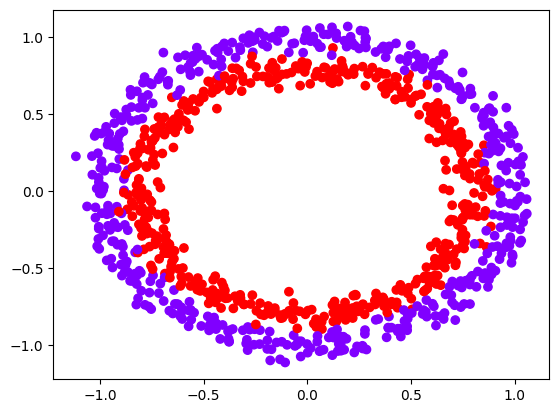

In [64]:
plt.scatter(data[:,0],data[:,1],c=target,cmap="rainbow")

In [65]:
X = torch.from_numpy(data).type(torch.float)
Y = torch.from_numpy(target).type(torch.float)
X[:4]

tensor([[ 0.7422,  0.2467],
        [-0.7340,  0.1687],
        [-0.8299,  0.2220],
        [-0.4291,  0.6722]])

In [66]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25)

In [67]:
class BinaryClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(in_features=2,out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10,out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10,out_features=1)
    )

  def forward(self,x:torch.Tensor):
    return self.layer1(x)



In [68]:
model_binary_classifier = BinaryClassifier()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_binary_classifier.parameters(),
                            lr=0.1)

In [69]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [70]:
epochs = 1001
for epoch in range(epochs):

  # model in train mode
  model_binary_classifier.train()

  # forward pass
  logits_train = model_binary_classifier(X_train).squeeze()

  # compute pred_train
  pred_train = torch.round(torch.sigmoid(logits_train))

  # compute accuracy train
  acc_train = accuracy_fn(y_true=Y_train,y_pred=pred_train)

  # compute loss
  logitloss_train = loss_fn(logits_train,Y_train)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  logitloss_train.backward()

  # optimizer step
  optimizer.step()

  if epoch%50 == 0:
    model_binary_classifier.eval()
    with torch.inference_mode():
      logits_test = model_binary_classifier(X_test).squeeze()
      pred_test = torch.round(torch.sigmoid(logits_test))
      logitloss_test = loss_fn(logits_test,Y_test)
      acc_test = accuracy_fn(y_true=Y_test,y_pred=pred_test)
      print(f"epoch:{epoch} loss_train:{logitloss_train} acc_train:{acc_train} loss_test:{logitloss_test} acc_test{acc_test}")


epoch:0 loss_train:0.6995269656181335 acc_train:50.13333333333333 loss_test:0.6967805027961731 acc_test49.6
epoch:50 loss_train:0.6937564015388489 acc_train:43.2 loss_test:0.6916686296463013 acc_test42.0
epoch:100 loss_train:0.6922940015792847 acc_train:48.53333333333333 loss_test:0.6907612085342407 acc_test52.0
epoch:150 loss_train:0.691213846206665 acc_train:50.4 loss_test:0.6901096105575562 acc_test53.6
epoch:200 loss_train:0.690242350101471 acc_train:51.866666666666674 loss_test:0.6894824504852295 acc_test52.0
epoch:250 loss_train:0.6892319321632385 acc_train:57.333333333333336 loss_test:0.6888157725334167 acc_test57.599999999999994
epoch:300 loss_train:0.6881138682365417 acc_train:56.666666666666664 loss_test:0.6882046461105347 acc_test55.60000000000001
epoch:350 loss_train:0.6868423819541931 acc_train:56.53333333333334 loss_test:0.6876509189605713 acc_test53.6
epoch:400 loss_train:0.6853421926498413 acc_train:56.13333333333333 loss_test:0.6870933175086975 acc_test51.6
epoch:450 l

In [71]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

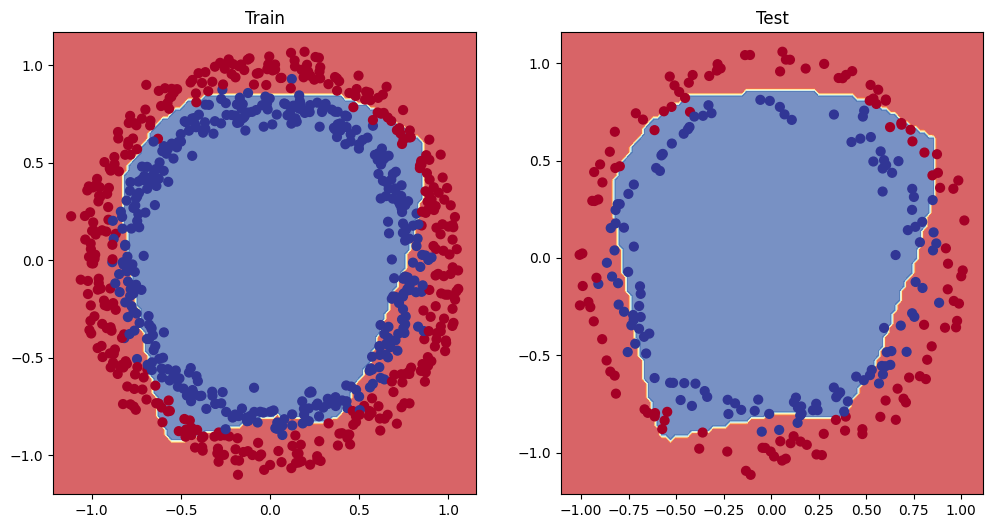

In [72]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_binary_classifier, X_train, Y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_binary_classifier, X_test, Y_test) # model_3 = has non-linearity

In [84]:
class BinaryClassifier1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(in_features=2,out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10,out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10,out_features=1)
    )

  def forward(self,x:torch.Tensor):
    return torch.sigmoid(self.layer1(x))

In [85]:
model_binary_classifier1 = BinaryClassifier1()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params=model_binary_classifier1.parameters(),
                            lr=0.1)

In [86]:
epochs = 1001
for epoch in range(epochs):

  # model in train mode
  model_binary_classifier1.train()

  # forward pass
  pred_prob_train = model_binary_classifier1(X_train).squeeze()

  # compute pred_train
  pred_train = torch.round(torch.sigmoid(pred_prob_train))

  # compute accuracy train
  acc_train = accuracy_fn(y_true=Y_train,y_pred=pred_train)

  # compute loss
  loss_train = loss_fn(pred_train,Y_train)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss_train.backward()

  # optimizer step
  optimizer.step()

  if epoch%50 == 0:
    model_binary_classifier1.eval()
    with torch.inference_mode():
      pred_prob_test = model_binary_classifier1(X_test).squeeze()
      pred_test = torch.round(torch.sigmoid(pred_prob_test))
      loss_test = loss_fn(pred_test,Y_test)
      acc_test = accuracy_fn(y_true=Y_test,y_pred=pred_test)
      print(f"epoch:{epoch} loss_train:{loss_train} acc_train:{acc_train} loss_test:{loss_test} acc_test{acc_test}")

epoch:0 loss_train:50.13333511352539 acc_train:49.86666666666667 loss_test:49.599998474121094 acc_test50.4
epoch:50 loss_train:50.13333511352539 acc_train:49.86666666666667 loss_test:49.599998474121094 acc_test50.4
epoch:100 loss_train:50.13333511352539 acc_train:49.86666666666667 loss_test:49.599998474121094 acc_test50.4
epoch:150 loss_train:50.13333511352539 acc_train:49.86666666666667 loss_test:49.599998474121094 acc_test50.4
epoch:200 loss_train:50.13333511352539 acc_train:49.86666666666667 loss_test:49.599998474121094 acc_test50.4
epoch:250 loss_train:50.13333511352539 acc_train:49.86666666666667 loss_test:49.599998474121094 acc_test50.4
epoch:300 loss_train:50.13333511352539 acc_train:49.86666666666667 loss_test:49.599998474121094 acc_test50.4
epoch:350 loss_train:50.13333511352539 acc_train:49.86666666666667 loss_test:49.599998474121094 acc_test50.4
epoch:400 loss_train:50.13333511352539 acc_train:49.86666666666667 loss_test:49.599998474121094 acc_test50.4
epoch:450 loss_train:5

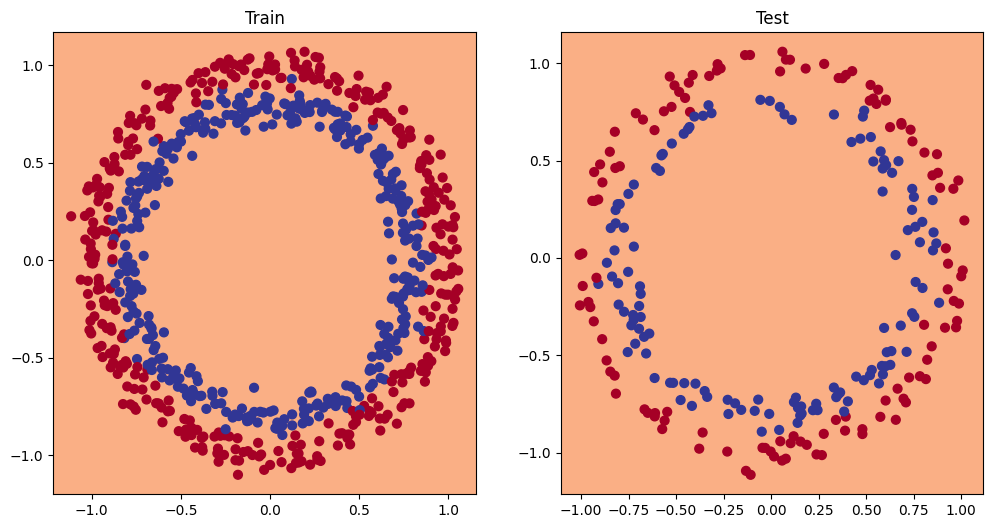

In [87]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_binary_classifier1, X_train, Y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_binary_classifier1, X_test, Y_test) # model_3 = has non-linearity